Adapted from:
<a href="https://colab.research.google.com/github/flatplanet/Pytorch-Tutorial-Youtube/blob/main/simple_NeuralNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import project_functions as pf
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import csv
import plotly
#import plotly.graph_obcalled_listects as go
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import unittest
import os
from sklearn.model_selection import train_test_split



In [2]:
#The Second Model is based on price data of different metals as well as oil, a commodity
ti_ppi_df = pd.read_csv("Relevant Data/ti_ppi_df.csv")
display(ti_ppi_df)
ti_ppi_df['net_change'] = ti_ppi_df['shifted_close'] - ti_ppi_df['close']
ti_ppi_df['percent_change'] = (ti_ppi_df['net_change'] / ti_ppi_df['close']) * 100
#ti_ppi_df.to_csv('Relevant Data/ti_ppi_df.csv', index=False)


,new_index,time,close,shifted_close,linear_p_x,quad_p_x,cubic_p_x,net_change,percent_change
0,0,1971-01-01,27.2,27.3,31.176075,17.518617,38.307471,0.1,0.367647
1,1,1971-02-01,27.3,27.6,31.471688,17.938576,38.348878,0.3,1.098901
2,2,1971-03-01,27.6,28.2,31.767300,18.358157,38.392783,0.6,2.173913
3,3,1971-04-01,28.2,28.2,32.062912,18.777361,38.439178,0.0,0.000000
4,4,1971-05-01,28.2,28.2,32.358524,19.196186,38.488054,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
655,655,2025-08-01,233.4,233.4,224.802082,211.639744,192.347876,0.0,0.000000
656,656,2025-09-01,233.4,233.8,225.097694,211.812143,192.150326,0.4,0.171380
657,657,2025-10-01,233.8,234.0,225.393306,211.984164,191.949538,0.2,0.085543
658,658,2025-11-01,234.0,234.0,225.688919,212.155807,191.745505,0.0,0.000000


In [3]:
# Model_1 is based on derivatives, regressed predictions, of the base time series
class Model_1(nn.Module):
  # Input layer (new index, 3 regressed values, and more associated features to predict percentage change totaled to 6) -->
  # Hidden Layer1 (number of neurons) -->
  # H2 (n) -->
  # output (I want one numeric prediction)
  def __init__(self, in_features=6, h1=12, h2=10, out_features=1):
    super().__init__() # instantiate our nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.out(x)

    return x


In [5]:
# Pick a manual seed for randomization
torch.manual_seed(37)
# Create an instance of model
model = Model_1()
my_df = ti_ppi_df
# Remove the last row as it doesn't have the associated prediction. 
my_df = my_df.iloc[:-1]


#transform my_df into a [0, 1] scaled matrix. Let's drop time and shifted close earlier so we don't have to create edge cases...
my_df = my_df.drop('time', axis=1)
my_df = my_df.drop('shifted_close', axis=1)


t_back_min, t_back_max = min(my_df['percent_change']), max(my_df['percent_change'])
#Transform back minimun and maximun


my_df_scaled = my_df
my_df_scaled['new_index'] = pf.scale01(my_df_scaled['new_index'])
my_df_scaled['close'] = pf.scale01(my_df_scaled['close'])
my_df_scaled['linear_p_x'] = pf.scale01(my_df_scaled['linear_p_x'])
my_df_scaled['quad_p_x'] = pf.scale01(my_df_scaled['quad_p_x'])
my_df_scaled['cubic_p_x'] = pf.scale01(my_df_scaled['cubic_p_x'])
my_df_scaled['net_change'] = pf.scale01(my_df_scaled['net_change'])
my_df_scaled['percent_change'] = pf.scale01(my_df_scaled['percent_change'])
    




In [6]:
# Train Test Split!  Set X, y
X = my_df_scaled
X = X.drop('percent_change', axis=1)
y = my_df['percent_change']
# Convert these to numpy arrays
X = X.values
y = y.values
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=41)

# Convert X features to float tensors
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)

# Convert y labels to float tensors
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

# Set the criterion of model to measure the error, how far off the predictions are from the data - PyTorch Forum suggest MSELoss
criterion = nn.MSELoss()
# Choose Adam Optimizer, lr = learning rate (if error doesn't go down after a bunch of iterations (epochs), lower our learning rate)
optimizer = torch.optim.Adam(model.parameters(), lr=0.015)

# Train our model!
# Epochs? (one run thru all the training data in our network)
epochs = 200
losses = []
#set this parameter to try to resolve error

for i in range(epochs):
  # Go forward and get a prediction
    y_pred = model.forward(X_train) # Get predicted results
    y_pred = y_pred[:,0]

  # Measure the loss/error, gonna be high at first

    loss = criterion(y_pred, y_train) # predicted values vs the y_train

  # Keep Track of our losses
    losses.append(loss.detach().numpy())

  # print every 10 epoch
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

  # Do some back propagation: take the error rate of forward propagation and feed it back
  # thru the network to fine tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


Epoch: 0 and loss: 0.005347975064069033
Epoch: 10 and loss: 0.002223839284852147
Epoch: 20 and loss: 0.0019828041549772024
Epoch: 30 and loss: 0.0018349357414990664
Epoch: 40 and loss: 0.0017742323689162731
Epoch: 50 and loss: 0.0017095585353672504
Epoch: 60 and loss: 0.0016354130348190665
Epoch: 70 and loss: 0.0015480219153687358
Epoch: 80 and loss: 0.0014274559216573834
Epoch: 90 and loss: 0.0012675264151766896
Epoch: 100 and loss: 0.001050476566888392
Epoch: 110 and loss: 0.0008012450416572392
Epoch: 120 and loss: 0.0010567014105618
Epoch: 130 and loss: 0.0008208290091715753
Epoch: 140 and loss: 0.000628650130238384
Epoch: 150 and loss: 0.00049477384891361
Epoch: 160 and loss: 0.0004502278461586684
Epoch: 170 and loss: 0.00040826344047673047
Epoch: 180 and loss: 0.00038173829670995474
Epoch: 190 and loss: 0.0003609930572565645


Text(0.5, 0, 'Epoch')

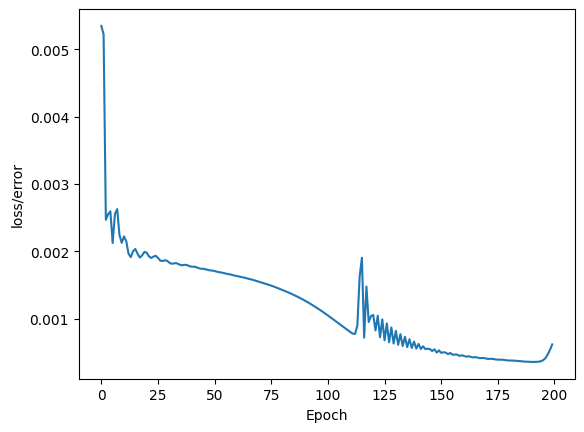

In [7]:
# Graph it out!
plt.plot(range(epochs), losses)
plt.ylabel("loss/error")
plt.xlabel('Epoch')

In [8]:
# Evaluate Model on Test Data Set (validate model on test set)
with torch.no_grad():  # Basically turn off back propogation
    y_eval = model.forward(X_test) # X_test are features from our test set, y_eval will be predictions
    y_eval = y_eval[:,0]
    loss = criterion(y_eval, y_test) # Find the loss or error


Text(0, 0.5, 'Change in Basis Points')

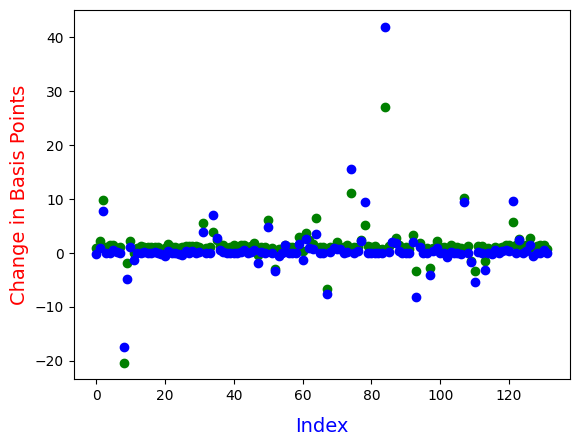

In [10]:

y_eval_t_b = pf.scale01_t_back(y_eval, t_back_min, t_back_max)
y_test_t_b = pf.scale01_t_back(y_test, t_back_min, t_back_max)

plt.scatter(range(len(y_eval_t_b)) , y_eval_t_b, c='green', label='Predicted' ) 
plt.scatter(range(len(y_test_t_b)) , y_test_t_b, c='blue', label='Actual' ) 

plt.xlabel("Index", fontsize=14, color='blue', labelpad=10)
plt.ylabel("Change in Basis Points", fontsize=14, color='red', rotation=90)


We are 99% confident that our predictions are correct within 6.712477684020996 basis points of the ML model output.


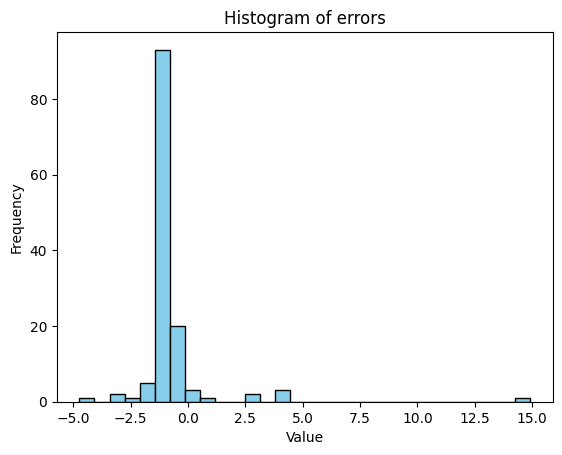

In [11]:
#Calculate uncertainties / error associated with model - Statement of confidence associated with prediction

nn_1_errors = y_test_t_b - y_eval_t_b

std_dev_nn_1 = np.std(nn_1_errors)
safety_factor = 1.5

#k-value for 99% confidence
conf_99 = 2.576

margin_of_error = conf_99 * safety_factor * std_dev_nn_1

print(f"We are 99% confident that our predictions are correct within {margin_of_error} basis points of the ML model output." )

plt.hist(nn_1_errors, bins=30, color='skyblue', edgecolor='black') # `bins` defines the number of intervals

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of errors')

# 4. Display the plot
plt.show()




In [12]:
# Save our NN Model
torch.save(model.state_dict(), 'M1_PPI_reg.pt')
# Load the Saved Model

saved_model = Model_1()
saved_model.load_state_dict(torch.load('M1_PPI_reg.pt', weights_only=False))
#Confirms that our saved model is indeed what we expect
saved_model.eval()


Model_1(
  (fc1): Linear(in_features=6, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=1, bias=True)
)

In [14]:
next_month_Ti_PPI_input = torch.FloatTensor(X[-1])


with torch.no_grad():  # Basically turn off back propogation
    output = saved_model.forward(next_month_Ti_PPI_input) # X_test are features from our test set, y_eval will be predictions

next_month_prediction = pf.scale01_t_back(output, t_back_min, t_back_max)
print(f"We are 99% confident that the price change from {ti_ppi_df["time"][len(ti_ppi_df["time"])-2]} to {ti_ppi_df["time"][len(ti_ppi_df["time"])-1]} is between { round((next_month_prediction[0] - margin_of_error)[0], 2) } and { round((next_month_prediction[0] + margin_of_error)[0], 2) } basis points. ")
print(f"This prediction is validated by the most recent basis point change of {ti_ppi_df["percent_change"] [len(ti_ppi_df["percent_change"]) - 2] * 100}.")


We are 99% confident that the price change from 2025-11-01 to 2025-12-01 is between -6.269999980926514 and 7.150000095367432 basis points. 
This prediction is validated by the most recent basis point change of 0.0.
